In [215]:
#we start by importing all the necessary libraries
import os
import sys
import numpy as np
import pandas as pd
import re
import warnings
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sktime.forecasting.arima import AutoARIMA
import pandas as pd
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.arima import AutoARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error


In [216]:
#reding and analyzing the data
df = pd.read_csv(filepath_or_buffer="parkingLot.csv")
print(df.head())
print(df.shape)


  vehicle_no            timestamp  camera_id
0   MHUN7063  2024-09-12 05:00:00          1
1   MHYN4677  2024-09-12 05:00:00          1
2   MHEL6595  2024-09-12 05:00:00          1
3   MHNQ2590  2024-09-12 05:00:00          1
4   MHHA0518  2024-09-12 05:00:00          1
(106694, 3)


### Filtering the Data Based on the following parameters
- dropping all the NA values 
- removing duplicate values if any
- removing all the timestamps which happen after 12 am and before 5 am (as given the mall is closed in this time)
- removing if some vehichle number doesn't follow a given general vehichle regex


In [217]:
def valid_vehicle_no(vehicle_no):
    pattern = r'^[A-Z]{4}[0-9]{4}$'
    return bool(re.match(pattern=pattern, string=vehicle_no))

print(f"Shape Before Filtering : {df.shape}")

df = df.dropna()
df = df.sort_values(by='timestamp')
df = df.drop_duplicates()


df['timestamp'] = pd.to_datetime(df['timestamp'])
mask = ~((df['timestamp'].dt.hour > 0) & (df['timestamp'].dt.hour < 5))
df = df[mask]
df = df[df['vehicle_no'].apply(valid_vehicle_no)]

print(f"Shape After Filtering  : {df.shape}")


Shape Before Filtering : (106694, 3)
Shape After Filtering  : (105978, 3)


### Merging

Now we merge the vehichles captured by the camera1 and camera2 into a complete database
identifying on each day when a vehicle entered the mall and exited the mall in the dataframe 
called merged_data, and assuring the following in the merged_data:

- A vehicles exit time > it's entry time
- A vehicle enters and exits the mall in the same day(to avoid huge outliers caused due to missing NA's having difference of multiple days    which does not make sense in a general sense in a real scenario )

In [218]:

camera_1 = df[df['camera_id'] == 1]
camera_2 = df[df['camera_id'] == 2]


merged_data = pd.merge(camera_1, camera_2, on='vehicle_no', suffixes=('_entry', '_exit'))

#convert 'timestamp_entry' and 'timestamp_exit' to datetime
merged_data['timestamp_entry'] = pd.to_datetime(merged_data['timestamp_entry'])
merged_data['timestamp_exit'] = pd.to_datetime(arg=merged_data['timestamp_exit'])

#ensure timestamps are on the same date by comparing just the date part
merged_data = merged_data[
    (merged_data['timestamp_entry'].dt.date == merged_data['timestamp_exit'].dt.date) &
    (merged_data['timestamp_entry'] <= merged_data['timestamp_exit'])
]

daily_counts = merged_data.groupby(merged_data['timestamp_entry'].dt.date)['vehicle_no'].nunique()

Now we will calculate the time spent by each vehicle in the parking lot by taking the differnce between the entry and exit timestamps and converting it to hours

In [219]:
warnings.filterwarnings(action="ignore")


merged_data['time_spent'] = (merged_data['timestamp_exit'] - merged_data['timestamp_entry']).dt.total_seconds() / 3600  # convert to hours

avg_time_spent = merged_data.groupby(by=merged_data['timestamp_entry'].dt.date)['time_spent'].mean()



In [220]:
warnings.filterwarnings("ignore")

# adapted from https://www.kaggle.com/kashnitsky/topic-9-part-1-time-series-analysis-in-python
def tsplot(y, lags=None, figsize=(12, 7)):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
           
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))

    y.plot(ax=ts_ax)
    p_value = sm.tsa.stattools.adfuller(y)[1]
    ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    plt.tight_layout()

### Analyzing
Now we analyze the data on multiple parameters:
- The Augmented Dickey–Fuller unit test examines if the time series is non-stationary
- The ACF and PACF values for different lags to examining the data and predict the Auto Regerssive and Moving average terms

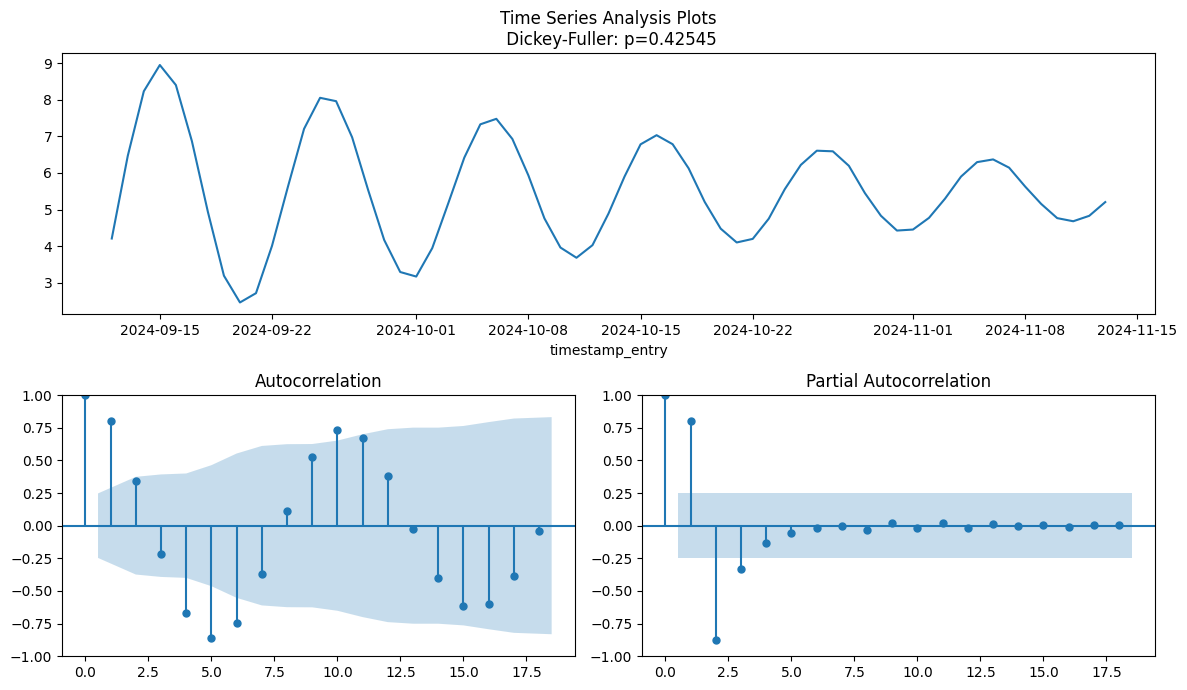

In [221]:
tsplot(avg_time_spent)

### Analysis
On analyzing the above data we see a very significant p_value > 40% 

- indicating that the series is non-stationary ,we are going to take the differnece of the series to see if the stationary becomes more-stationary
- Also we notice that the significant PACF value uptill the 4th lag and then dying with a sinusodial ACF graph indicating na AR model with p value around 4 with some seasonality

Let's analyze the difference and see if we could further conclude something

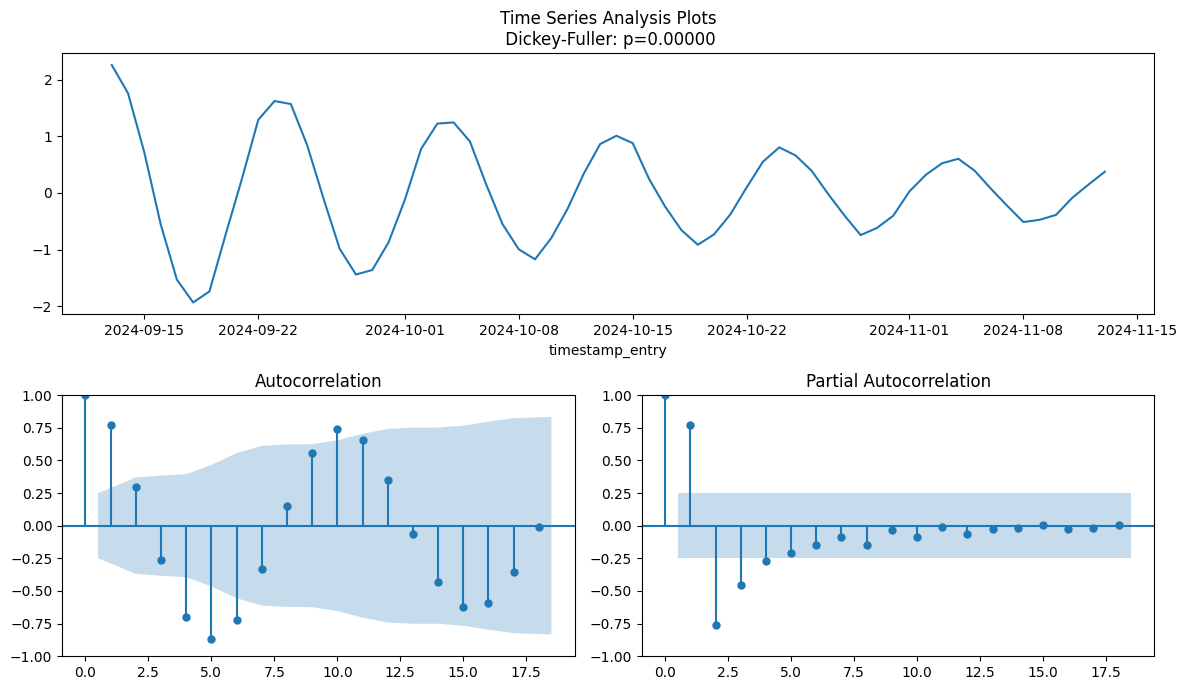

In [222]:
avg_time_spent_diff = (avg_time_spent - avg_time_spent.shift(1)).dropna()
tsplot(avg_time_spent_diff)

### Further Analysis
After taking the differnece of the series we notice that the p value = 0.000 indicating the series is now stationary, thus we conclude:
- the difference series is stationary implying d = 1
- it is an ARIMA(p , 1 , 0) where the p value is somewhere around 4

Thus, while training we will keep set **d = 1**, the AR term to be **3 <= p <= 6** , the MA term to be **q  = 0** , and the **seasonality = 14** days

Also we forecast using another fixed ARIMA(4,1,0) with seasonality = 14 along with the trained autoARIMA

In [224]:
warnings.filterwarnings("ignore")
y_time = pd.DataFrame(data=avg_time_spent, index=pd.to_datetime(avg_time_spent.index))

y_train_time, y_test_time = temporal_train_test_split(y_time, test_size=7)

#fitting the model using AUTO ARIMA
model_time = AutoARIMA(start_P = 3 , max_P = 6, start_q = 0 , max_q = 0 , d = 1 , suppress_warnings=True, seasonal=True , sp = 14)
model_time.fit(y=y_train_time)

y_pred_time = model_time.predict(fh=np.arange(1, 8))


#forecasting using fixed parameters for the SARIMAX model ARIMA(8,1,0) with a seasonality of 14 as inferreed from the various plots

sarimax_model = SARIMAX(endog=y_train_time, order=(4,1,0), seasonal_order=(1,1,2,14) ) 
sarimax_result = sarimax_model.fit(disp=False)
y_pred_time_sarima = sarimax_result.forecast(steps=7)



In [187]:
def mean_absolute_scaled_error(y_true, y_pred):

    mae = mean_absolute_error(y_true, y_pred)

    # Calculate the naive forecast errors
    naive_forecast = np.roll(y_true.astype(float), 1)  # Ensure it's float
    naive_forecast[0] = np.nan  # First value has no naive forecast
    naive_error = np.abs(y_true - naive_forecast)

    # Calculate the mean absolute error of the naive forecast (MAE)
    mae_naive = np.nanmean(naive_error)  # Ignore NaN values in the calculation
    
    # Calculate MASE
    mase = mae / mae_naive if mae_naive != 0 else np.nan  # Handle division by zero
    
    return mase

In [188]:
mase = mean_absolute_scaled_error(y_true=y_test_time, y_pred=y_pred_time)
mase_s = mean_absolute_scaled_error(y_true=y_test_time, y_pred=y_pred_time_sarima)


mape = mean_absolute_percentage_error(y_test_time, y_pred_time)
mape_s = mean_absolute_percentage_error(y_test_time, y_pred_time_sarima)

print(f"MASE uisng autoARIMA: {mase:.4f}")    
print(f"MAPE using autoARIMA: {mape * 100:.2f}%")  

print(f"MASE using SARIMAX: {mase_s:.4f}")    
print(f"MAPE using SARIMAX: {mape_s * 100:.2f}%")  


MASE uisng autoARIMA: 0.5170
MAPE using autoARIMA: 3.43%
MASE using SARIMAX: 0.2485
MAPE using SARIMAX: 1.67%


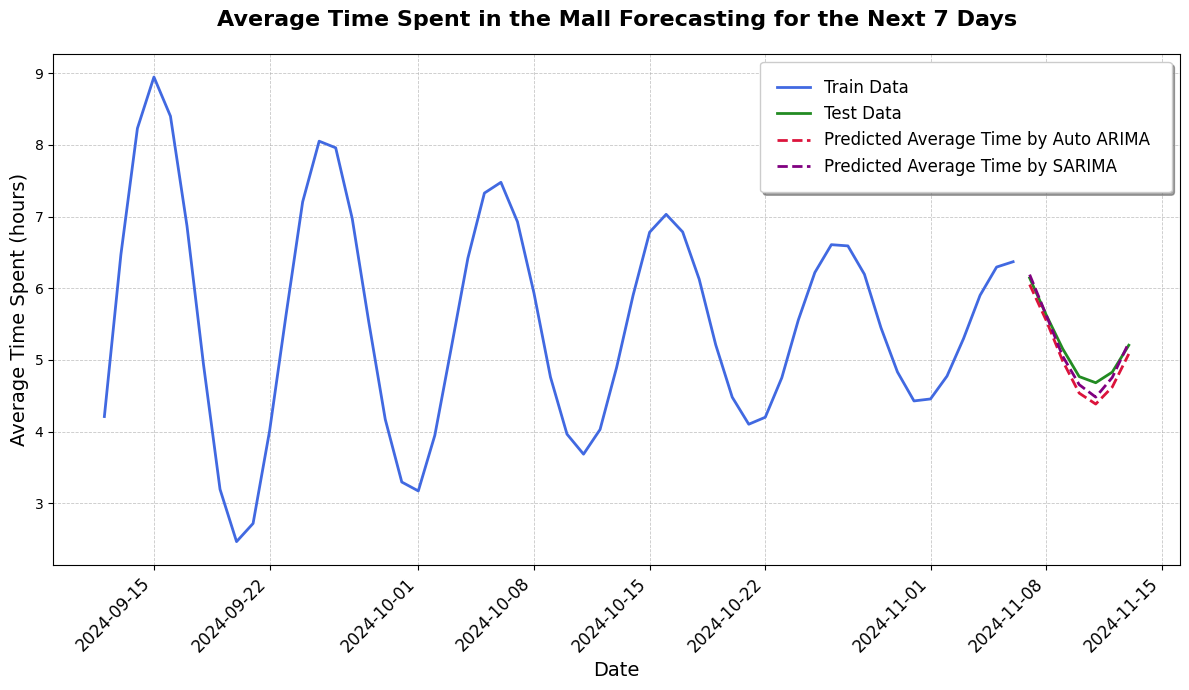

In [189]:
plt.figure(figsize=(12, 7))

plt.plot(y_train_time.index, y_train_time, label="Train Data", color='royalblue', linewidth=2)
plt.plot(y_test_time.index, y_test_time, label="Test Data", color='forestgreen', linewidth=2)

future_dates_time = pd.date_range(start=y_time.index[-8] + pd.Timedelta(days=1), periods=7)
plt.plot(future_dates_time, y_pred_time, label="Predicted Average Time by Auto ARIMA ", color='crimson', linestyle='--', linewidth=2)
plt.plot(future_dates_time, y_pred_time_sarima, label="Predicted Average Time by SARIMA", color='purple', linestyle='--', linewidth=2)


plt.title('Average Time Spent in the Mall Forecasting for the Next 7 Days', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Average Time Spent (hours)', fontsize=14)

plt.xticks(rotation=45, ha='right', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.6, alpha=0.7)

plt.legend(loc='upper right', fontsize=12, frameon=True, shadow=True, borderpad=1)
plt.tight_layout()

plt.show()
